In [81]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import hist
import matplotlib.pyplot as plt

In [92]:
NanoAODSchema.warn_missing_crossrefs = False

fname = "data/02905d4b-dde0-480f-baec-116d4998d612.root"
events = NanoEventsFactory.from_root(
    {fname: "Events"},
    schemaclass=NanoAODSchema,
).events()

In [56]:
events = events[:500]

In [93]:
events["HT"] = ak.sum(abs(events.Jet.pt), axis=1)
events["alpha"] = ak.fill_none(ak.pad_none(events.Jet,3)[:, 2].pt / events.HT,0)
cut_events = events[ak.num(events.Jet) > 1]

In [94]:
alph = (
    Hist.new.Reg(60, 0, 1, name="alpha", label="j3/HT ratio")
    .Weight()
)

In [95]:
alph.fill(events.alpha)

Hist(Regular(60, 0, 1, name='alpha', label='j3/HT ratio'), storage=Weight()) # Sum: WeightedSum(value=505920, variance=505920)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd0ebfd1100>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

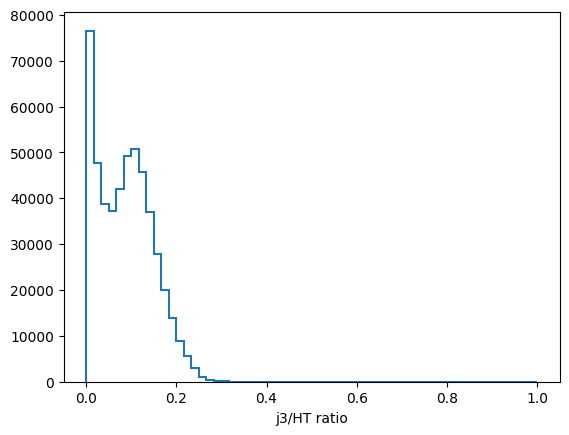

In [96]:
alph.plot1d()

In [97]:
h = (
    Hist.new.Reg(60, 0, 1000, name="mis-align", label="j1 - j2 pt [GeV]")
    .Weight()
)

In [98]:
h.fill(
    abs(cut_events.Jet[:, 0].pt - cut_events.Jet[:, 1].pt))

Hist(Regular(60, 0, 1000, name='mis-align', label='j1 - j2 pt [GeV]'), storage=Weight()) # Sum: WeightedSum(value=497811, variance=497811) (WeightedSum(value=505830, variance=505830) with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fd0ebfe9df0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

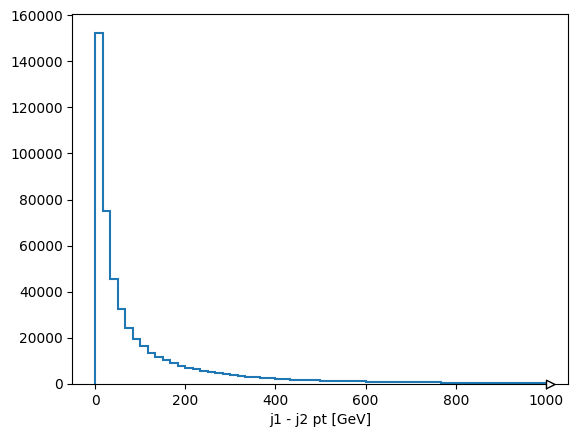

In [99]:
h.plot1d()

In [100]:
h2 = hist.Hist(
    hist.axis.Regular(40, 0, 400, name="mis-align", label="j1 - j2 pt [GeV]"),
    hist.axis.Regular(40, 0, 0.3, name="alpha", label="j3/HT ratio")
)

In [101]:
h2.fill(
    abs(cut_events.Jet[:, 0].pt - cut_events.Jet[:, 1].pt),
    cut_events.alpha
)

Hist(
  Regular(40, 0, 400, name='mis-align', label='j1 - j2 pt [GeV]'),
  Regular(40, 0, 0.3, name='alpha', label='j3/HT ratio'),
  storage=Double()) # Sum: 467986.0 (505830.0 with flow)

AttributeError: module 'matplotlib.pyplot' has no attribute 'zscale'

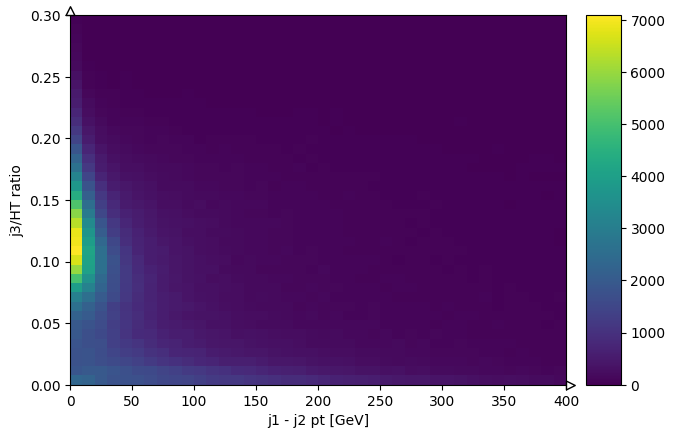

In [ ]:
h2.plot2d()